In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<p><center><font color='black' size = '5'>Contenido</font></center></p>


Los datos se generaron a partir de una serie de conjuntos de sensores idénticos, hechos a medida. Cada sensor se conectó a una Raspberry Pi. Cada uno de los dispositivos IoT se colocaron a tomar datos en 3 diferentes ubicaciones físicas con diversas condiciones ambientales.


| device            | environmental conditions                       |
|-------------------|------------------------------------------------|
| 00:0f:00:70:91:0a | condiciones estables, más frescas y más húmedas|
| 1c:bf:ce:15:ec:4d | temperatura y humedad muy variables            |
| b8:27:eb:bf:9d:51 | condiciones estables, más cálidas y secas      |

Cada dispositivo IoT recolectó un total de siete lecturas diferentes en un intervalo regular. Las lecturas provienen de los siguientes sensores que incluyen temperatura, humedad, monóxido de carbono (CO), gas licuado de petróleo (GLP), humo, luz y movimiento. Los datos abarcan el período comprendido entre el 12/07/2020 00:00:00 UTC y el 19/07/2020 23:59:59 UTC . Hay un total de 405.184 filas de datos.


Las lecturas del sensor, junto con una identificación de dispositivo única y una marca de tiempo, se publicaron como un solo mensaje, utilizando el protocolo de red de Transporte de Telemetría de Cola de Mensajes (MQTT) estándar ISO. A continuación se muestra un ejemplo de la carga de un mensaje MQTT.

1. ts (timestamp) ==> epoch
2. device id ==> object
3. CO (Carbon Monoxide) in ppm ==> float64
4. humidity in percent ==> float64
5. light ==> bool
6. LPG (liquified Petroleum Gas) in ppm ==> float64
7. motion ==> bool
8. smoke in ppm ==> float64
9. Temperature in Fahrenheit ==> float64

| column   | description          | units      |
|----------|----------------------|------------|
| ts       | timestamp of event   | epoch      |
| device   | unique device name   | string     |
| co       | carbon monoxide      | ppm (%)    |
| humidity | humidity             | percentage |
| light    | light detected?      | boolean    |
| lpg      | liquid petroleum gas | ppm (%)    |
| motion   | motion detected?     | boolean    |
| smoke    | smoke                | ppm (%)    |
| temp     | temperature          | Fahrenheit |

<p><center><font color='black' size = '5'>Modelo de Minimos Cuadrados Ordinarios</font></center></p>

<p><center><font color='black' size = '5'>Modelo de Regresion Lineal</font></center></p>

<p><left><font color='black' size = '5'>Guardo el datasets en la variable data y realizo algunos procesos de preprocesamiento de datos</font></left></p>

In [112]:
data = pd.read_csv("iot_telemetry_data.csv")
data.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [113]:
data['motion'].value_counts()

False    404702
True        482
Name: motion, dtype: int64

In [4]:
print(data.shape)

(405184, 9)


In [5]:
data.isnull().sum()

ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64

In [6]:
data = data.copy()
data = data.drop(['motion'], axis = 1)
data.head()

,ts,device,co,humidity,light,lpg,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,0.020448,22.600000


In [7]:
print(data.shape)

(405184, 8)


In [8]:
data.describe()

,ts,co,humidity,lpg,smoke,temp
count,4.051840e+05,405184.000000,405184.000000,405184.000000,405184.000000,405184.000000
mean,1.594858e+09,0.004639,60.511694,0.007237,0.019264,22.453987
std,1.994984e+05,0.001250,11.366489,0.001444,0.004086,2.698347
min,1.594512e+09,0.001171,1.100000,0.002693,0.006692,0.000000
25%,1.594686e+09,0.003919,51.000000,0.006456,0.017024,19.900000
50%,1.594858e+09,0.004812,54.900000,0.007489,0.019950,22.200000
75%,1.595031e+09,0.005409,74.300003,0.008150,0.021838,23.600000
max,1.595203e+09,0.014420,99.900002,0.016567,0.046590,30.600000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   smoke     405184 non-null  float64
 7   temp      405184 non-null  float64
dtypes: bool(1), float64(6), object(1)
memory usage: 22.0+ MB


In [10]:
from sklearn.preprocessing import LabelEncoder

encLab = LabelEncoder()
deviceEnc = pd.DataFrame(encLab.fit_transform(data['device']), columns=['device_condition'])
deviceEnc.index = data.index

dataEnc = pd.concat([data, deviceEnc], axis=1)
dataEnc.head()

,ts,device,co,humidity,light,lpg,smoke,temp,device_condition
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,0.020411,22.700000,2
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,0.013275,19.700001,0
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,0.020475,22.600000,2
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,0.018628,27.000000,1
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,0.020448,22.600000,2


In [11]:
encLab2 = LabelEncoder()
lightEnc = pd.DataFrame(encLab2.fit_transform(dataEnc['light']), columns=['lights'])
lightEnc.index = dataEnc.index

dataEnc2 = pd.concat([dataEnc, lightEnc], axis=1)
dataEnc2.head()

,ts,device,co,humidity,light,lpg,smoke,temp,device_condition,lights
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,0.020411,22.700000,2,0
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,0.013275,19.700001,0,0
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,0.020475,22.600000,2,0
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,0.018628,27.000000,1,1
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,0.020448,22.600000,2,0


<p><left><font color='black' size = '5'>Acontinuacion inicio el proceso de procesamiento de datos y analizo</font></left></p>

In [12]:
dataProcessed = dataEnc2.drop(['device', 'light'], axis=1)
dataProcessed.head()

,ts,co,humidity,lpg,smoke,temp,device_condition,lights
0,1.594512e+09,0.004956,51.000000,0.007651,0.020411,22.700000,2,0
1,1.594512e+09,0.002840,76.000000,0.005114,0.013275,19.700001,0,0
2,1.594512e+09,0.004976,50.900000,0.007673,0.020475,22.600000,2,0
3,1.594512e+09,0.004403,76.800003,0.007023,0.018628,27.000000,1,1
4,1.594512e+09,0.004967,50.900000,0.007664,0.020448,22.600000,2,0


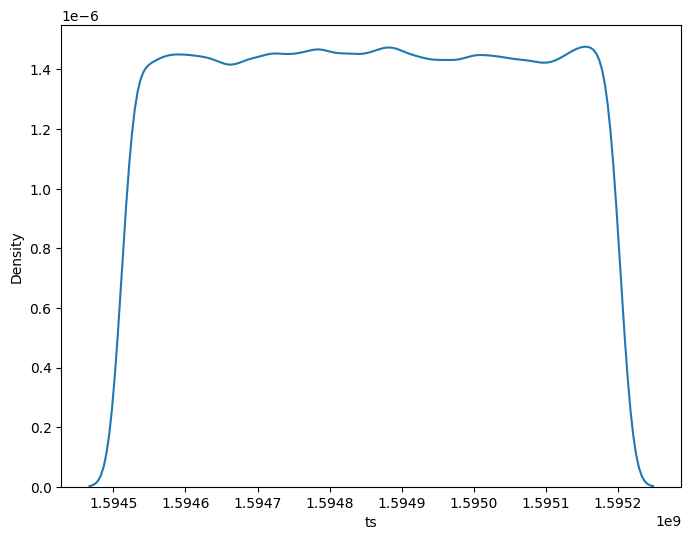

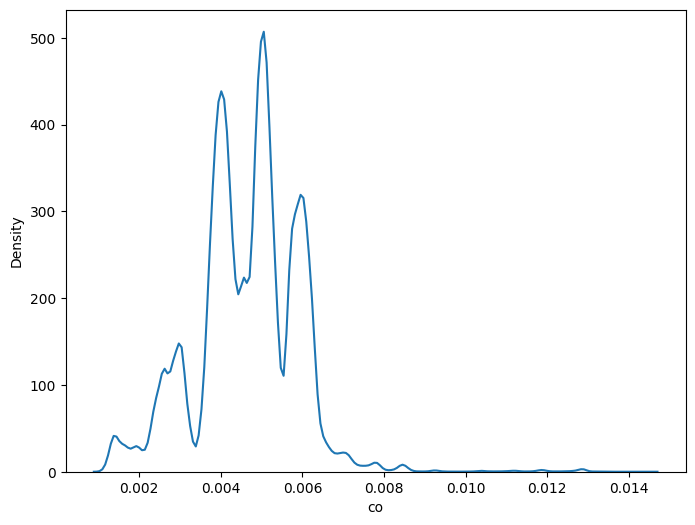

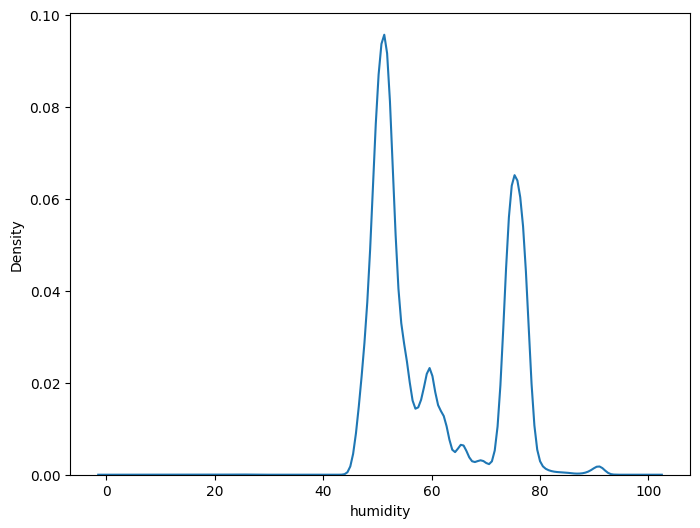

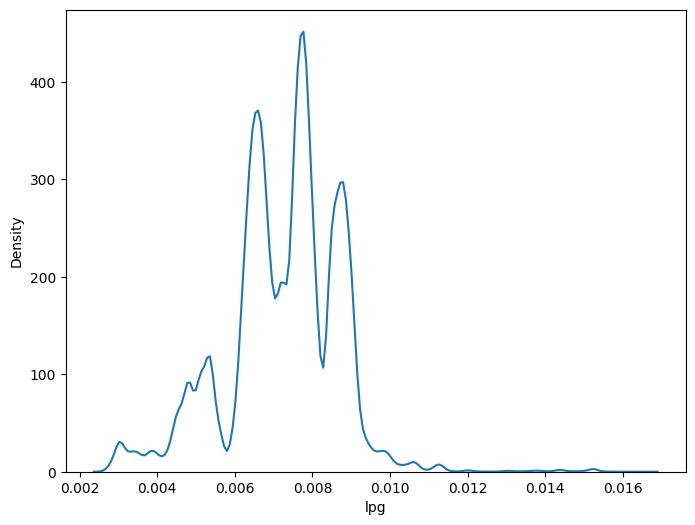

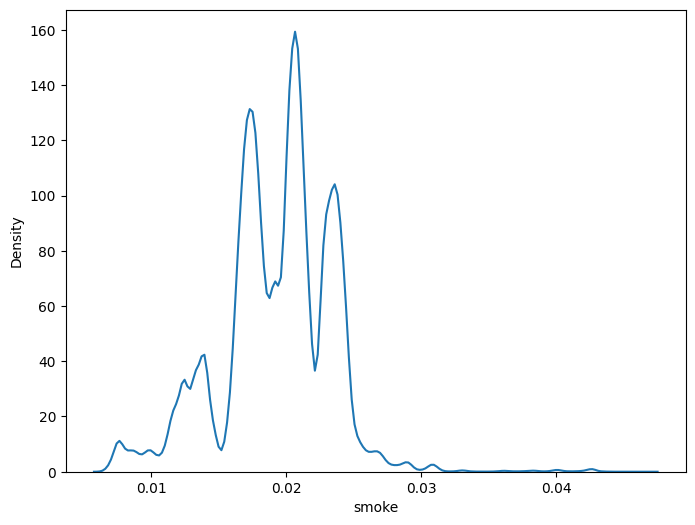

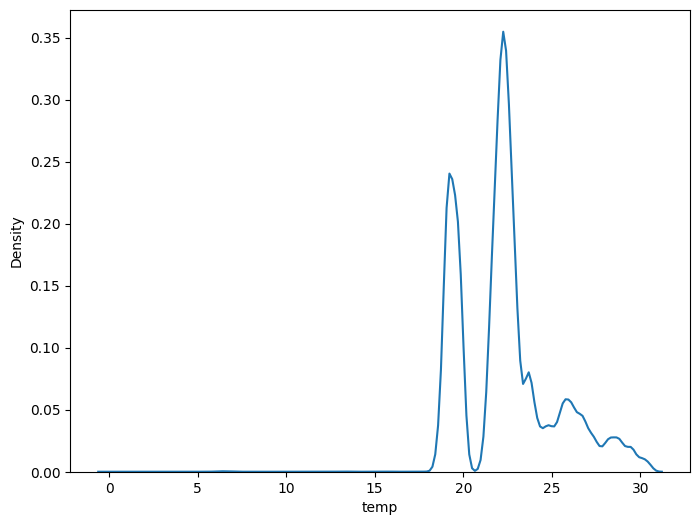

In [13]:
for i in dataProcessed.columns:
    if dataProcessed[i].nunique() > 5:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(x=i, data=dataProcessed)
        plt.show()

<p><left><font color='black' size = '5'>En las anteriores graficas podemos observar en comportamiento de cada una de las variables </font></left></p>

<AxesSubplot: >

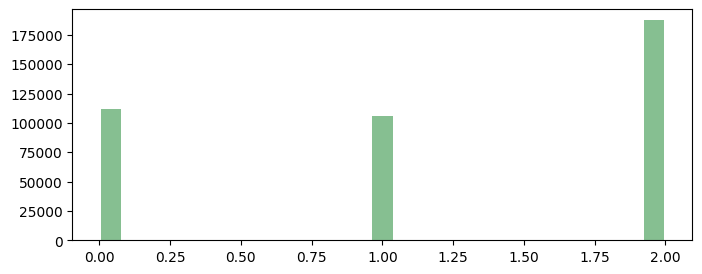

In [71]:
dataProcessed.device_condition.hist(bins=25, grid=False, figsize=(8,3), color='#86bf91', rwidth=0.9)

<p><left><font color='black' size = '5'>En los anteriores Histogramas podemos observar tanto el comportamiento que tienen cada una de las condiciones que tanto son las frecuencias de cada una de ellos logrando observar que la condicion 2 (condiciones estables, más cálidas y secas ) se respite de forma mas significativa que las demas</font></left></p>

<AxesSubplot: >

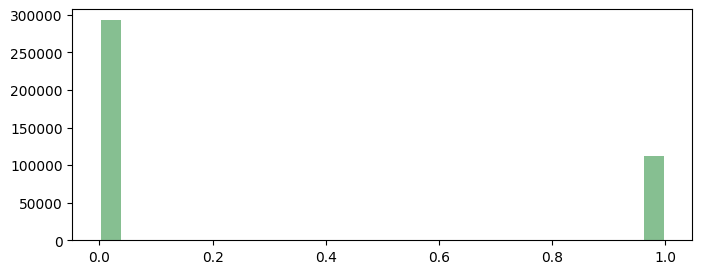

In [73]:
dataProcessed.lights.hist(bins=25, grid=False, figsize=(8,3), color='#86bf91', rwidth=0.9)

<p><left><font color='black' size = '5'>En los anteriores Histogramas podemos observar  el comportamiento de la variable lights en donde podemos observar que con mas frecuencia no detecto luz</font></left></p>

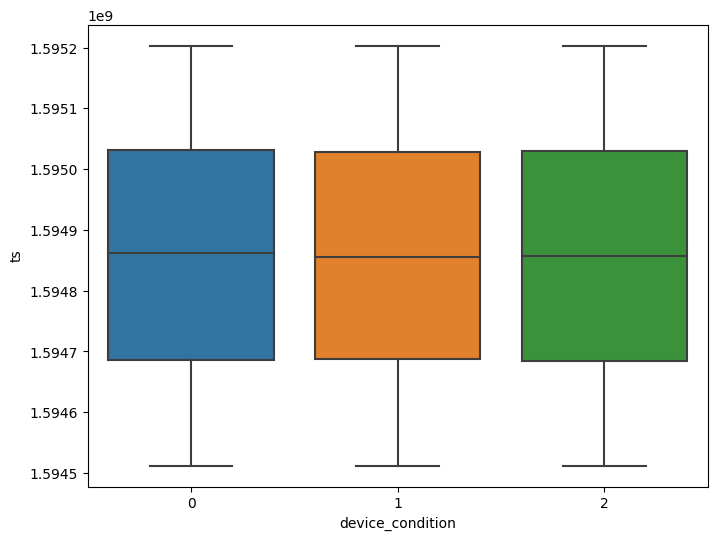

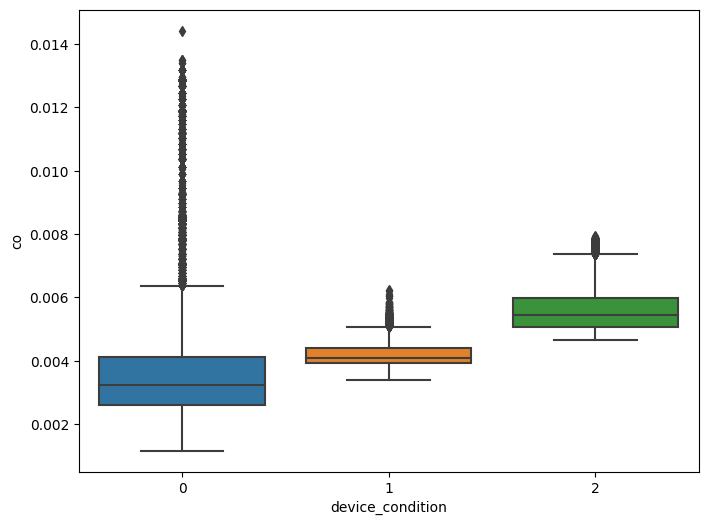

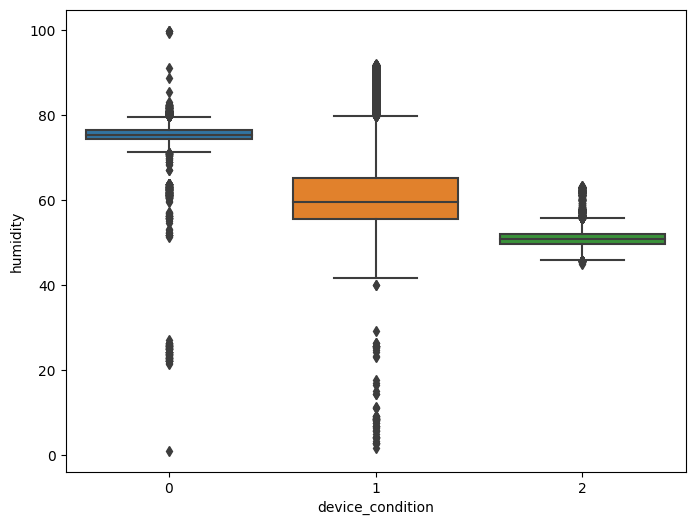

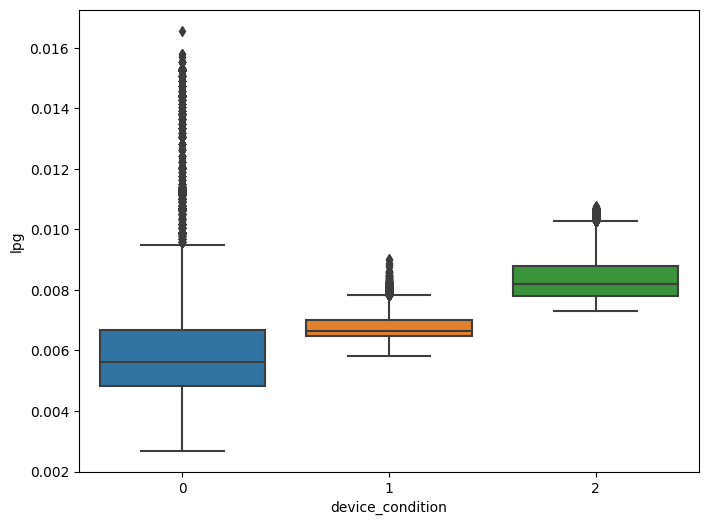

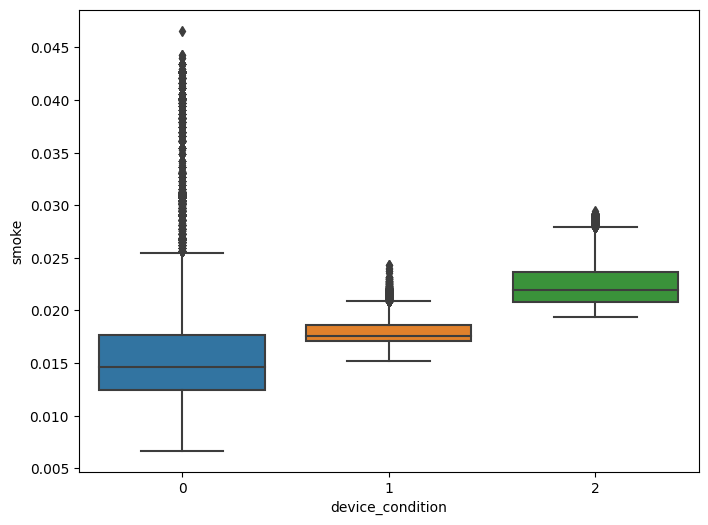

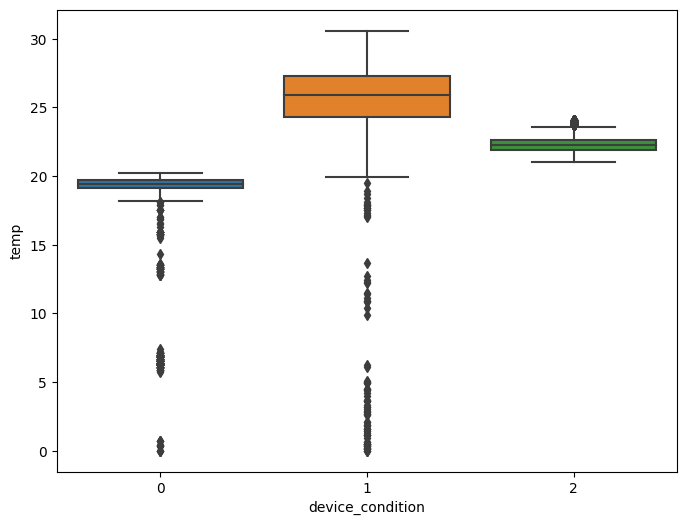

In [75]:
for k in dataProcessed.columns:
    if dataProcessed[k].nunique() > 5:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=dataProcessed['device_condition'], y=dataProcessed[k])
        plt.show()

<p><left><font color='black' size = '5'>En los anteriores Histogramas podemos observar el comportamiento dependiendo de las tres condiciones <br><br>
En la temperatura podemos observar como existe un rango menos amplio, indicandonos que los datos están más próximos,con algunos valores atipicos.<br><br>
En la humedad podemos observar igualmente existe un rango menos amplio, indicandonos que los datos están más próximos,con algunos valores atipicos.<br><br>
En las demas variables podemos observar  mucha dispersion de los datos podemos observar como tambien existe un rango dentro de los cuartiles muy  amplio, indicandonos que los datos están muy disperso,con muchos valores atipicos.</n>
</font></left></p>

<AxesSubplot: >

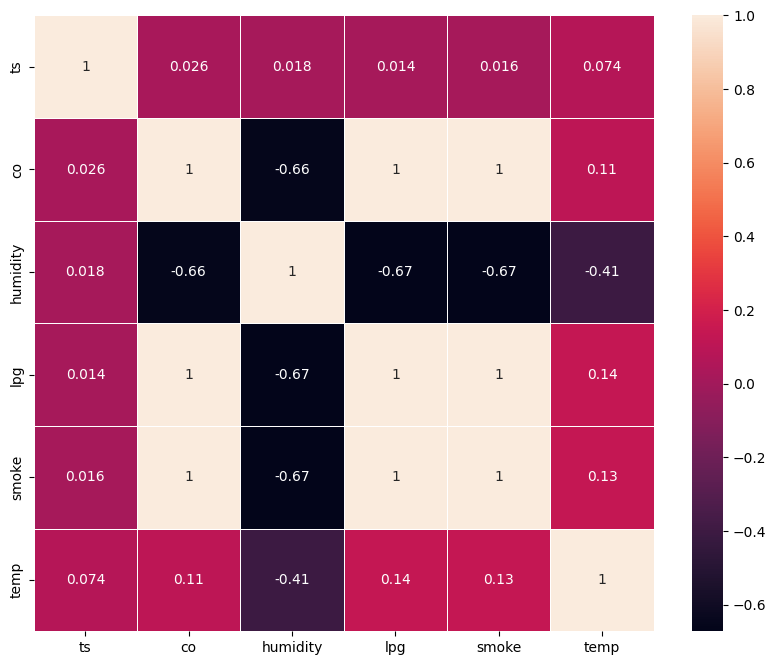

In [14]:
dataCorr = dataProcessed.drop(['lights', 'device_condition'], axis=1)
corr = dataCorr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, linewidths=.5)

<p><left><font color='black' size = '5'>En la anterior matriz de correlacion podemos concluir lo siguientes <br><br>
las variables lpg, smoke, co. no generan un aporte por estar altamente correlacionados, no son representativos para el modelo<br><br>
por lo tanto tenemos humedad y temperatura, estas variables son representativas<br><br>
tomaremos la luz como variable que nos puede ser representativo para nuestro modelo
</font></left></p>


<p><center><font color='black' size = '5'>DATA LISTA PARA EL PROCESO DE APLICACION DE LOS DIFERENTES MODELOS</font></center></p>

In [111]:
data_limpia_input = dataProcessed.copy()
removedCol = ['lpg', 'smoke', 'co']

data_limpia = data_limpia_input.drop(removedCol, axis=1)
data_limpia.head()

,ts,humidity,temp,device_condition,lights
0,1.594512e+09,51.000000,22.700000,2,0
1,1.594512e+09,76.000000,19.700001,0,0
2,1.594512e+09,50.900000,22.600000,2,0
3,1.594512e+09,76.800003,27.000000,1,1
4,1.594512e+09,50.900000,22.600000,2,0


<p><left><font color='black' size = '5'>A modo de aprendizaje y comparacion realizare un proceso de estandarizacion para el modelo de LinearRegresion
</font></left></p>

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model   import LinearRegression
from sklearn.model_selection import train_test_split

In [96]:
X_cols = list(set(data_limpia.columns)-set(['ts','device_condition']))
y_cols = ['device_condition']

X = data_limpia[X_cols].values
y = data_limpia[y_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [18]:
y_cols

['device_condition']

In [19]:
y

array([[2],
       [0],
       [2],
       ...,
       [1],
       [0],
       [2]])

In [20]:
X_cols

['lights', 'temp', 'humidity']

In [21]:
X

array([[ 0.        , 22.7       , 51.        ],
       [ 0.        , 19.70000076, 76.        ],
       [ 0.        , 22.6       , 50.9       ],
       ...,
       [ 1.        , 26.60000038, 75.69999695],
       [ 0.        , 19.20000076, 75.30000305],
       [ 0.        , 22.2       , 48.4       ]])

In [23]:
X_test[:5]

array([[ 1.61269072,  2.35181755, -0.44091891],
       [-0.6200817 , -0.24236622, -0.76643759],
       [ 1.61269072,  2.05533966,  0.43886129],
       [-0.6200817 , -1.09474098,  1.65295824],
       [-0.6200817 ,  0.23941082, -1.16233868]])

In [24]:
a = sc_x.inverse_transform(X_test)
a[:5]

array([[ 1.        , 28.79999924, 55.5       ],
       [ 0.        , 21.8       , 51.8       ],
       [ 1.        , 28.        , 65.5       ],
       [ 0.        , 19.5       , 79.30000305],
       [ 0.        , 23.1       , 47.3       ]])

In [83]:
y_pred_standarizada = model.predict(np.array([[1.61269072,  2.35181755, -0.44091891]]))
y_pred_standarizada

array([[0.38571845]])

In [84]:
predicion_desentandarizada = sc_y.inverse_transform(y_pred_standarizada)
predicion_desentandarizada

array([[1.5102485]])

In [97]:
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print("="*82)
print('r2 = ',r2)
print('mse = ',mse)
print("="*82)


r2 =  0.8232370984673475
mse =  0.17651719010979922


<p><left><font color='black' size = '5'>Entranamiento del modelo sin estandarizar para el modelo de LinearRegresion
</font></left></p>

In [87]:
X = data_limpia[X_cols].values
y = data_limpia[y_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


model_sin_standar = LinearRegression()
model_sin_standar.fit(X_train, y_train)

y_pred_sin_estandarizar = model_sin_standar.predict(X_test)

In [88]:
X_test

array([[ 1.        , 28.79999924, 55.5       ],
       [ 0.        , 21.8       , 51.8       ],
       [ 1.        , 28.        , 65.5       ],
       ...,
       [ 1.        , 24.89999962, 55.40000153],
       [ 0.        , 19.10000038, 77.80000305],
       [ 1.        , 29.5       , 49.90000153]])

In [89]:
y_pred_sin_estandarizar

array([[1.5102485 ],
       [1.78869408],
       [0.86001262],
       ...,
       [1.37449376],
       [0.07551161],
       [1.88355372]])

In [93]:
mse = metrics.mean_squared_error(y_test, y_pred_sin_estandarizar)
r2 = metrics.r2_score(y_test, y_pred_sin_estandarizar)
print("="*82)
print('r2 = ',r2)
print('mse = ',mse)
print("="*82)

r2 =  0.8232370984673473
mse =  0.12422341986537934


<p><left><font color='black' size = '5'>A continuacion podemos hacer procesos de predicion sin haber realizado el proceso de estandarizacion
</font></left></p>

In [118]:
#me traigo esta muestra de data para hacer unas prediciones a base de esta data
encLab2 = LabelEncoder()
lightEnc = pd.DataFrame(encLab2.fit_transform(dataEnc['light']), columns=['lights'])
lightEnc.index = dataEnc.index

dataEnc2 = pd.concat([dataEnc, lightEnc], axis=1)
dataEnc2[:10]

,ts,device,co,humidity,light,lpg,smoke,temp,device_condition,lights
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,0.020411,22.700000,2,0
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,0.013275,19.700001,0,0
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,0.020475,22.600000,2,0
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,0.018628,27.000000,1,1
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,0.020448,22.600000,2,0
5,1.594512e+09,1c:bf:ce:15:ec:4d,0.004391,77.900002,True,0.007009,0.018589,27.000000,1,1
6,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,0.020475,22.600000,2,0
7,1.594512e+09,00:0f:00:70:91:0a,0.002938,76.000000,False,0.005241,0.013628,19.700001,0,0
8,1.594512e+09,1c:bf:ce:15:ec:4d,0.004345,77.900002,True,0.006957,0.018440,27.000000,1,1
9,1.594512e+09,b8:27:eb:bf:9d:51,0.004970,50.900000,False,0.007667,0.020457,22.600000,2,0


| device            | environmental conditions                       | device_condition |
|-------------------|------------------------------------------------|------------------|
| 00:0f:00:70:91:0a | condiciones estables, más frescas y más húmedas|       0          |
| 1c:bf:ce:15:ec:4d | temperatura y humedad muy variables            |       1          |
| b8:27:eb:bf:9d:51 | condiciones estables, más cálidas y secas      |       2          |

In [129]:
lights = int(input("escriba 1 o 0 para luz"))
temp = float(input("escriba la temperatura"))
humidity = float(input("escriba la humedad"))
predicion_sin_standar = model_sin_standar.predict(np.array([[lights, temp, humidity]]))
s = float(predicion_sin_standar[0])
pre_redondeada =round(s)

if pre_redondeada == 0:
    print('condiciones estables, más frescas y más húmedas')
    print(pre_redondeada)
    print(s)
elif pre_redondeada == 1:
    print('temperatura y humedad muy variables ')
    print(pre_redondeada)
    print(s)
elif pre_redondeada == 2:
    print('condiciones estables, más cálidas y secas ')
    print(pre_redondeada)
    print(s)
elif pre_redondeada >= 4:
    print('no existe una condicion para estas variables')

condiciones estables, más frescas y más húmedas
0
0.20915333105493517


<p><center><font color='black' size = '4'>Modelo Ridge</font></center></p>

In [99]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

In [102]:
modelo_ridge = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

_ = modelo_ridge.fit(X_train, y_train)

y_pred_ridge = modelo_ridge.predict(X_test)

In [108]:
X_test

array([[ 1.61269072,  2.35181755, -0.44091891],
       [-0.6200817 , -0.24236622, -0.76643759],
       [ 1.61269072,  2.05533966,  0.43886129],
       ...,
       [ 1.61269072,  0.90648658, -0.44971658],
       [-0.6200817 , -1.24297993,  1.52099121],
       [ 1.61269072,  2.61123624, -0.93359569]])

In [105]:
predicciones = modelo_ridge.predict(X_test)
predicciones

array([[ 0.38572604],
       [ 0.71762244],
       [-0.38936708],
       ...,
       [ 0.22388092],
       [-1.32452619],
       [ 0.83071421]])

In [110]:
import sklearn.metrics as metrics

mse = metrics.mean_squared_error(y_test, y_pred_ridge)
r2 = metrics.r2_score(y_test, y_pred_ridge)
print("="*82)
print('r2 = ',r2)
print('mse = ',mse)
print("="*82)

r2 =  0.823237092697195
mse =  0.17651719587193085
